# pix2pix: Image-to-image translation with a conditional GAN

## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## Load the dataset

In [2]:
dataset_name = "data/paintings/"
PATH = dataset_name

In [3]:
sample_image = tf.io.read_file(PATH + 'train/0001.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

Metal device set to: Apple M1 Max
(390, 290, 3)


2022-02-25 08:43:01.063388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-25 08:43:01.063548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Show example

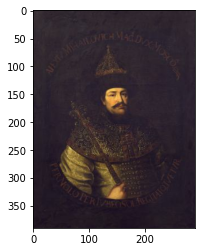

In [4]:
plt.figure()
plt.imshow(sample_image)

In [5]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Convert both images to float32 tensors
    input_image = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(tf.cast(image, tf.float32)))
    real_image = tf.cast(image, tf.float32)
    input_image = tf.image.resize(input_image, [512,512])
    real_image = tf.image.resize(real_image, [512,512])

    return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

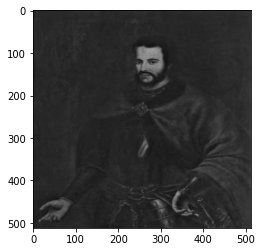

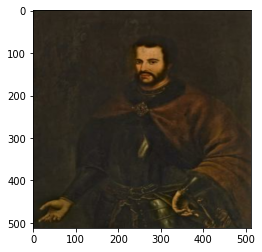

In [6]:
inp, re = load(str(PATH + 'train/0002.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the pix2pix paper, you need to apply random jittering and mirroring (Verwackeln und Spiegeln) to preprocess the training set.

Define several functions that:

* Resize each 512 x 512 image to a larger height and width—550 x 550.
* Randomly crop it back to 512 x 512.
* Randomly flip the image horizontally i.e. left to right (random mirroring).
* Normalize the images to the [-1, 1] range.

In [7]:
# The facade training set consist of 400 images
BUFFER_SIZE = 929
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 512x512 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

### Augmentierungsfunktionen

In [8]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [10]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [11]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 550x550
    input_image, real_image = resize(input_image, real_image, 550, 550)

    # Random cropping back to 512x512
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

You can inspect some of the preprocessed output:

2022-02-25 08:43:01.600110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-25 08:43:01.600847: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-25 08:43:01.600929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


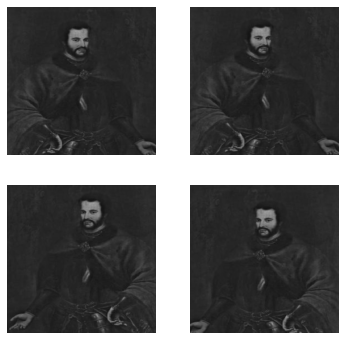

In [12]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [13]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

### Build an input pipeline with `tf.data`

In [14]:
train_dataset = tf.data.Dataset.list_files(str(PATH + 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
    test_dataset = tf.data.Dataset.list_files(str(PATH + 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH + 'val/*.jpg'))
    
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the generator

In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [17]:
down_model = downsample(3, 3) # 3 = output-dim, 4 ist die Kernel Size
# inp ist das Beispielbild nr. 100 (512x512)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


Define the upsampler (decoder):

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [19]:
up_model = upsample(3, 4)
up_result = up_model(tf.reshape(inp, [1,512,512,3]))
print (up_result.shape)

(1, 1024, 1024, 3)


Define the generator with the downsampler and the upsampler:

In [20]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    down_stack = [
      downsample(64, 4, apply_batchnorm=False),  # (batch_size, 300, 300, 64)
      downsample(128, 4),  # (batch_size, 150, 150, 128)
      downsample(256, 4),  # (batch_size, 75, 75, 256)
      downsample(512, 4),  # (batch_size, 37, 37, 512)
      downsample(512, 4),  # (batch_size, 18, 18, 512)
      downsample(512, 4),  # (batch_size, 5, 5, 512)
      downsample(512, 4),  # (batch_size, 3, 3, 512)
      downsample(512, 4),  # (batch_size, 2, 2, 512)
      downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    up_stack = [
      upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
      upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
      upsample(512, 4),  # (batch_size, 16, 16, 1024)
      upsample(512, 4),  # (batch_size, 32, 32, 512)
      upsample(256, 4),  # (batch_size, 64, 64, 512)
      upsample(128, 4),  # (batch_size, 128, 128, 256)
      upsample(64, 4),   # (batch_size, 256, 256, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # OUTPUT_CHANNELS = 3 (rgb!)
    # Output between -1 and 1
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        # print(up,"|||",skip)
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

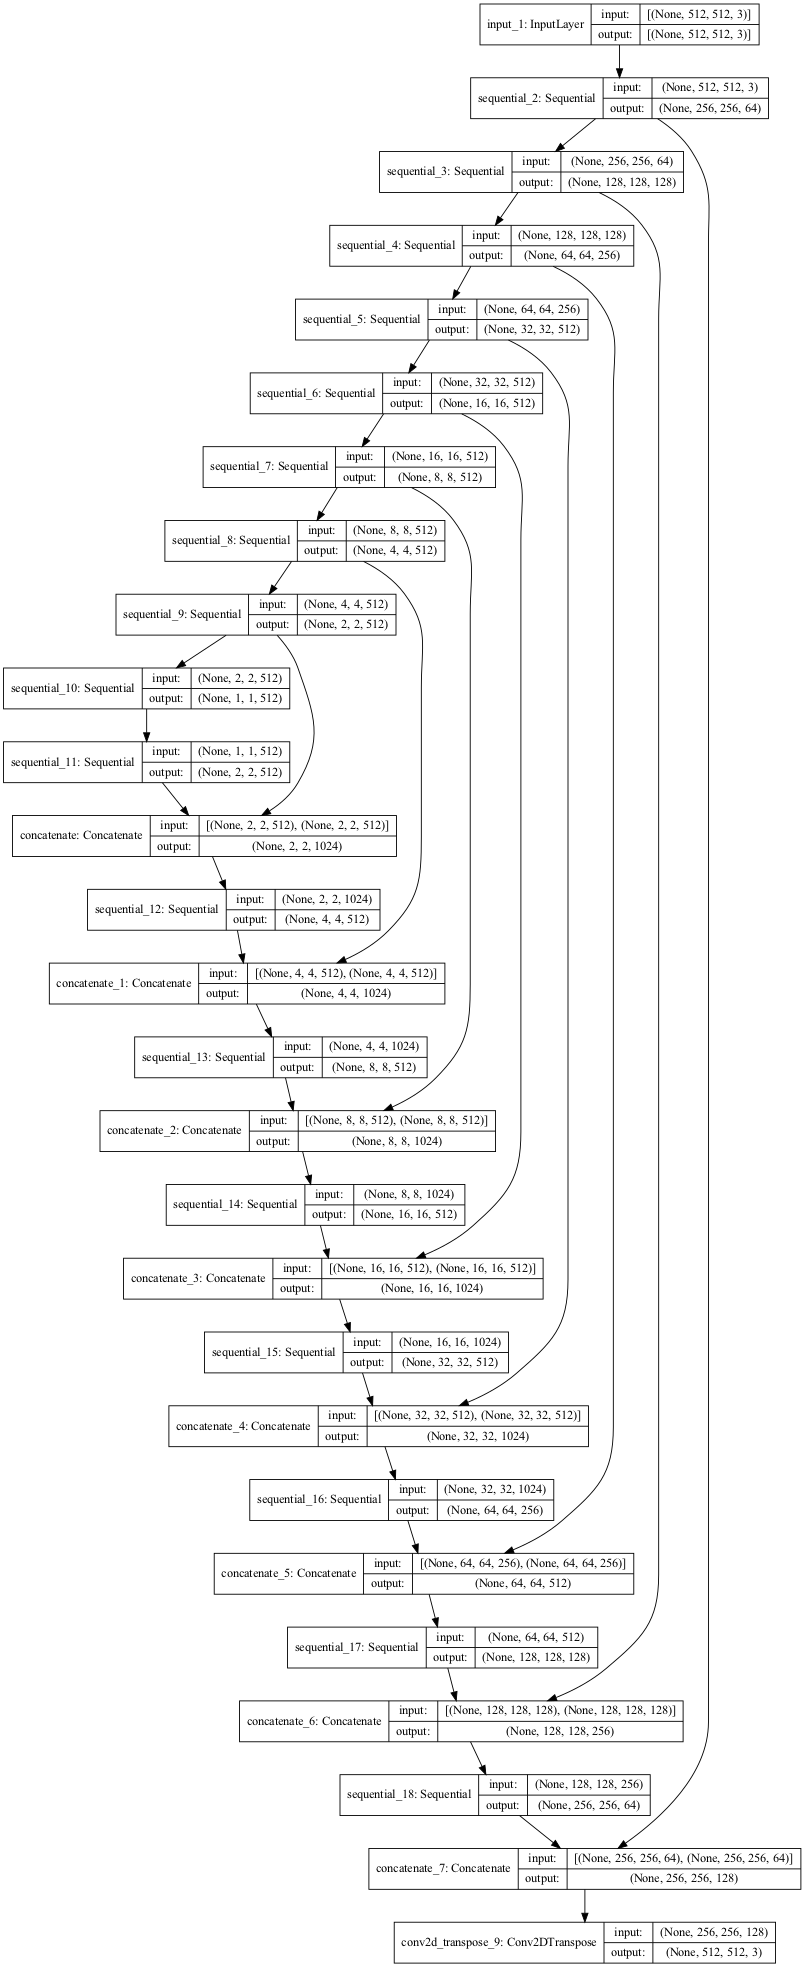

In [21]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


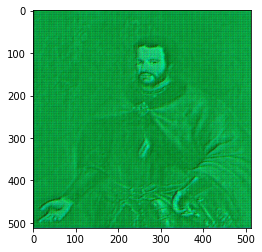

In [22]:
gen_output = generator(tf.reshape(inp,[1,512,512,3]), training=False)
plt.imshow(gen_output[0, ...])

### Define the generator loss
GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

* The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
* The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
* This allows the generated image to become structurally similar to the target image.
* The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

In [23]:
LAMBDA = 100

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # reduce_mean ist the arithmetic mean
    # tf.abs = Absolute Difference
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1" width="300px"/>

Build the discriminator
The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.

* Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
* The shape of the output after the last layer is (batch_size, 30, 30, 1).
* Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
* The discriminator receives 2 inputs:
  * The input image and the target image, which it should classify as real.
  * The input image and the generated image (the output of the generator), which it should classify as fake.
  * Use tf.concat([inp, tar], axis=-1) to concatenate these 2 inputs together.
Let's define the discriminator:

In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

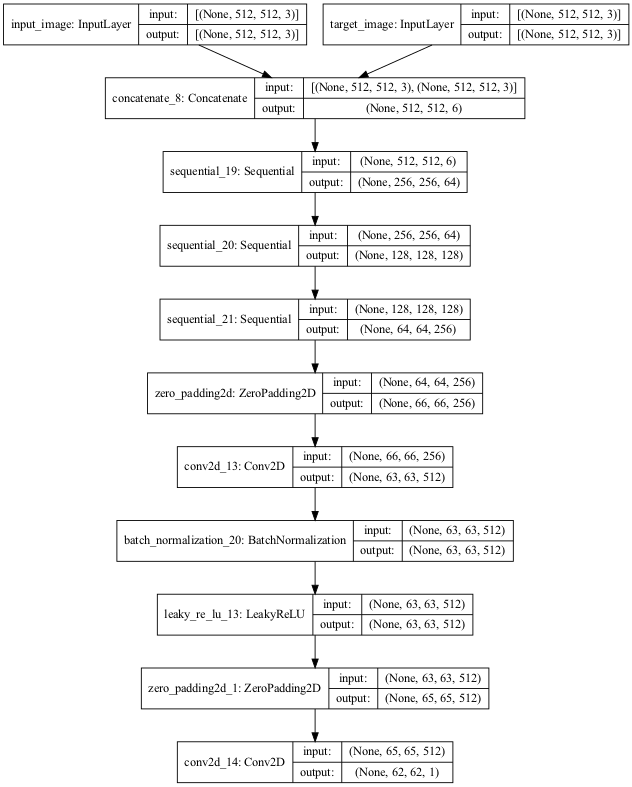

In [27]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

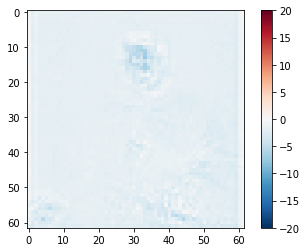

In [28]:
disc_out = discriminator([tf.reshape(inp,[1,512,512,3]), gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

* The discriminator_loss function takes 2 inputs: real images and generated images.
* real_loss is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
* generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
* The total_loss is the sum of real_loss and generated_loss.

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # disc_real_output ist im Optimalfall identisch mit einem Array bestehend aus "1"en
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    # der generierte output des discriminator loss ist im Idialfall "0"en
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

The training procedure for the discriminator is shown below. To learn more about the architecture and the hyperparameters you can refer to the pix2pix paper.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1" width="30%"/>

### Define the optimizers and a checkpoint-saver

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

* Pass images from the test set to the generator.
* The generator will then translate the input image into the output.
* The last step is to plot the predictions and voila!

In [32]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Test the function:

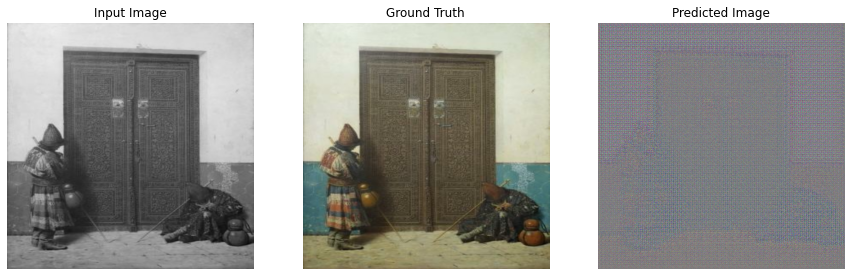

In [33]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training

* For each example input generates an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Finally, log the losses to TensorBoard.


In [34]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [35]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

* Iterates over the number of steps.
* Every 10 steps print a dot (.).
* Every 1k steps: clear the display and run generate_images to show the progress.
* Every 5k steps: save a checkpoint.

In [36]:
for num, _ in enumerate(train_dataset):
    pass

print(f'Number of elements: {num*16}')

Number of elements: 32656


In [37]:
from IPython.display import display as inline_display
from IPython.core.display import HTML

In [38]:
def fit(train_ds, test_ds, epochs):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    
    current_batch = 0
    batch_per_epoch = len(train_ds)
    
    for epoch in range(1, epochs):
        current_batch = 0
        
        display.clear_output(wait=True)
        if epoch > 1:
            print(f'Time taken for last epoch: {time.time()-start:.2f} sec\n')
        start = time.time()
        generate_images(generator, example_input, example_target)
        
        dh = inline_display(HTML('<pre>'+f'Epoch: {epoch} | '+'Batch: '+str(current_batch)+"/"+str(batch_per_epoch)+'</pre>'), display_id = True)
        
        for (input_image, target) in train_ds.shuffle(1024):
            train_step(input_image, target, epoch)
            current_batch += 1
            dh.update(HTML('<pre>'+f'Epoch: {epoch} | '+'Batch: '+str(current_batch)+"/"+str(batch_per_epoch)+'</pre>'))
        # Save model after epoch
        checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [39]:
#%load_ext tensorboard
#%tensorboard --logdir {log_dir}

Finally, run the training loop:

Time taken for last epoch: 592.26 sec



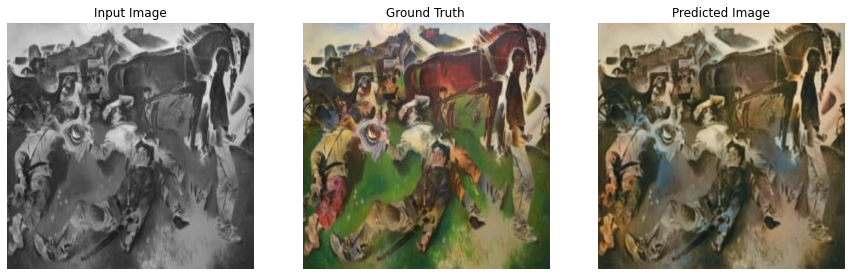

2022-02-25 08:53:05.508495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [40]:
fit(train_dataset, test_dataset, epochs=3)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

* Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
* For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
* For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.
* As training progresses, the gen_l1_loss should go down.


### Generate some images using the test set

In [41]:
# ls {checkpoint_dir}

In [42]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

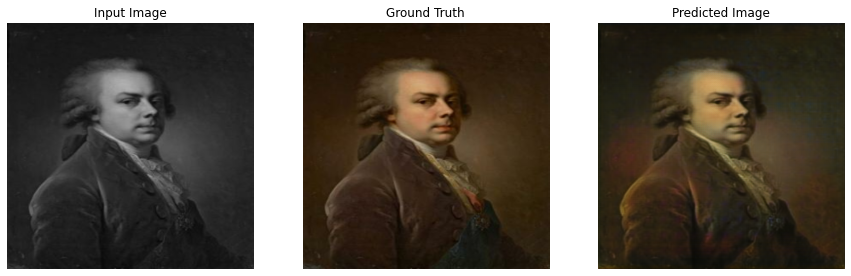

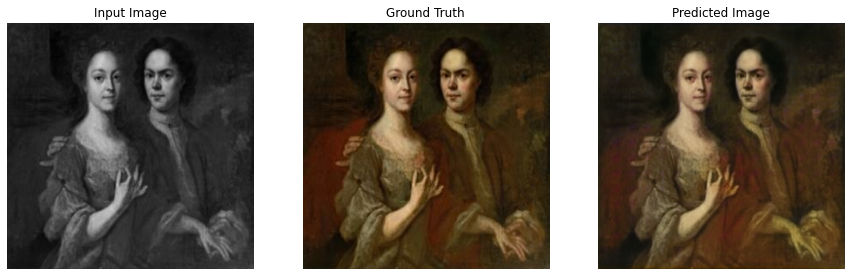

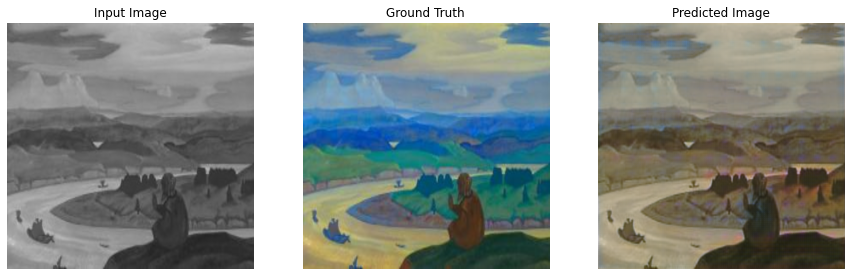

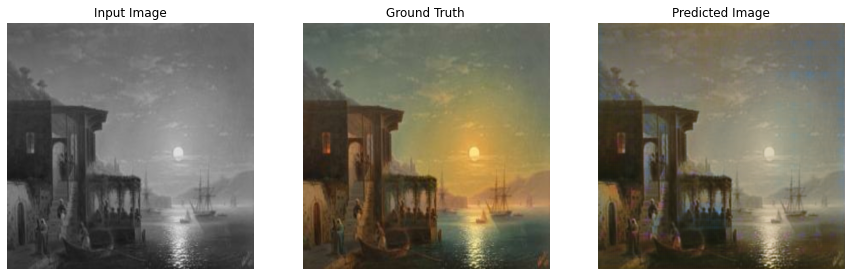

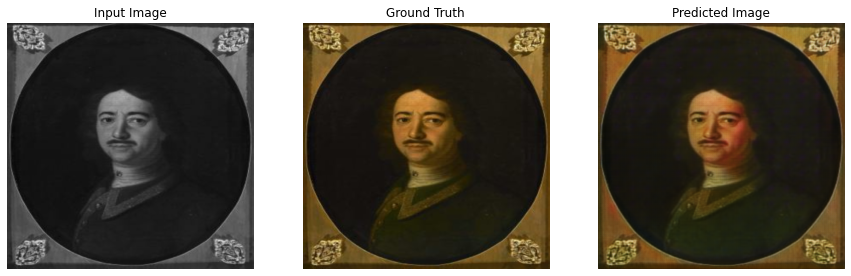

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)